In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt 


In [15]:
# from torchattacks import RPGD

In [16]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = './models/lenet_mnist_model.pth' #pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [17]:
# from google.colab import drive
# drive.mount('/gdrive')


In [18]:
# simply define a silu function
def srelu(input, slope):
    return slope * F.relu(input)

class SReLU(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input, slope):
        return srelu(input, slope) # simply apply already implemented SiLU

In [19]:
# LeNet Model definition
class NetTest(nn.Module):
    def __init__(self, slope):
        super(NetTest, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.slope = slope

    def forward(self, x):
#         s = torch.tensor(.7, requires_grad=False)        
        x = srelu(F.max_pool2d(self.conv1(x), 2), self.slope)
        x = srelu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2), self.slope)    
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = srelu(self.fc1(x), self.slope)
#         x = F.relu(self.fc1(x))        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x #F.log_softmax(x, dim=1)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")



CUDA Available:  False


In [20]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=False)

In [21]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [22]:
def test( model, device, test_loader, epsilon, myTarget):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target, myTarget = data.to(device), target.to(device), myTarget.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        if init_pred.item() == myTarget.item():            
            continue

        # Calculate the loss
        # loss = F.nll_loss(output, target)

        loss = F.nll_loss(output, myTarget)        

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, -1*data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == myTarget.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
#         else:
#             # Save some adv examples for visualization later
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
slopes   = [.5, 1, 2, 5, 10, 100]
symbs = ['*-', 'o-', 's-', 'd-', '+-', 'x-', '^-', '<-']


all_all_accuracies = []

for num in range(10):

    all_accuracies = []
    all_examples = []

    # Run test for each slope
    for sl in slopes:
        print(f'\n Running digit={num} slope={sl} ... ')
        # Initialize the network
        model = NetTest(sl).to(device)

        # Load the pretrained model
        model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

        # Set the model in evaluation mode. In this case this is for the Dropout layers
        model.eval()

        # Run test for each epsilon
        def_accuracies = []
        def_examples = []
    #     myTarget = torch.tensor([2])    
        for eps in epsilons:
            myTarget = torch.tensor([num]) #torch.randint(10, (1,1)).squeeze(0)        
    #         myTarget = torch.randint(10, (1,1)).squeeze(0)                
            acc, ex = test(model, device, test_loader, eps, myTarget)
            def_accuracies.append(acc)
#             def_examples.append(ex)

        all_accuracies.append(def_accuracies)
#         all_examples.append(def_examples)

    all_all_accuracies.append(all_accuracies)
    
    all_accuracies = np.array(all_accuracies)
    # all_accuracies = all_accuracies.T    
    fig =plt.figure(figsize=(5,5))
    for idx in range(len(all_accuracies)):
        plt.plot(all_accuracies[idx,:], symbs[idx])

    #     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
    plt.yticks(np.arange(0, .7, step=0.1))
    plt.xticks(np.arange(0, len(epsilons), step=1), epsilons)
    plt.title(f"Accuracy vs Epsilon (converting to {num})")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.legend(slopes)
    plt.show()
    fig.savefig(f'./figs/plot-{num}.png')

np.save(all_all_accuracies,'./Tmp/accs_MNIST.npy')



 Running digit=0 slope=0.5 ... 


In [1]:
range(len(all_accuracies))

NameError: ignored

In [ ]:
all_res = np.array(all_all_accuracies)
all_res_m = all_res.mean(axis=0).T

NameError: ignored

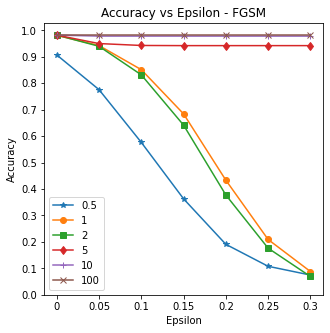

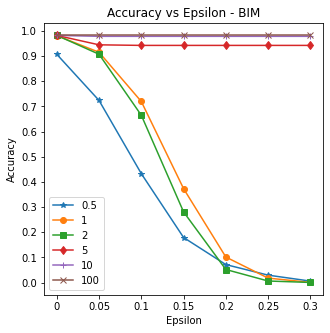

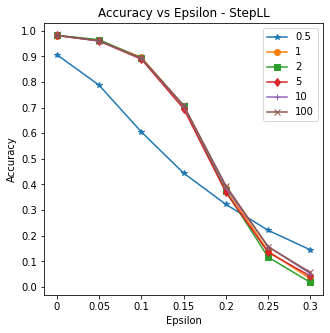

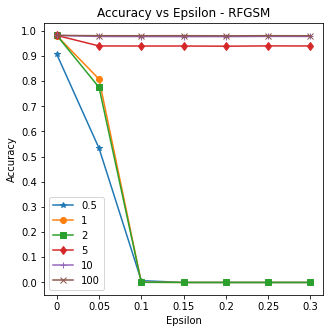

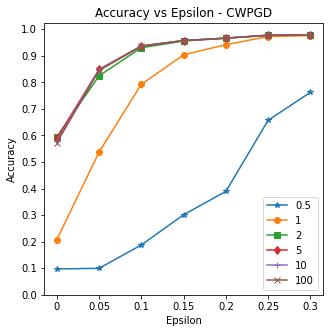

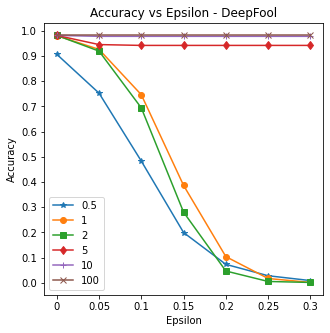

In [ ]:
fig =plt.figure(figsize=(5,5))
for idx in range(1,len(all_res_m)):
    plt.plot(all_res_m[:,idx], symbs[idx])

#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, .7, step=0.1))
plt.xticks(np.arange(0, 7, step=1), epsilons)
plt.title(f"Accuracy vs Epsilon (Avg. over digits)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(slopes[1:])
plt.show()
fig.savefig(f'avg.png')


In [ ]:
torch.save(all_all_accuracies,'/gdrive/My Drive/Tmp/accs_MNISTz.npy')

In [ ]:
model = NetTest(1).to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

# Run test for each epsilon
def_accuracies = []
def_examples = []

eps = .2

myTarget = torch.tensor([6]) #torch.randint(10, (1,1)).squeeze(0)        
acc, ex = test(model, device, test_loader, eps, myTarget)
def_accuracies.append(acc)
def_examples.append(ex)

    
    

Epsilon: 0.2	Test Accuracy = 871 / 10000 = 0.0871


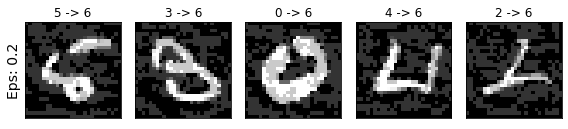

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for j in range(len(def_examples[0])):
    cnt += 1
    if len(def_examples[0]) ==1:
        continue
    plt.subplot(1,len(def_examples[0]),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel("Eps: {}".format(eps), fontsize=14)
    orig,adv,ex = def_examples[0][j]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()